# Convolutional Neural Networks


In [ ]:
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import Sequence

import numpy as np
import os
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator
from keras import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras import datasets, layers, models
from keras import metrics
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

First, we iniialized our data augmentation process to generate training, validation, and testing sets. We utilized Data Augmentation to  improve the performance of a CNN model for nodule detection by increasing the size and diversity of the training data, and by making the model more robust to variations in nodule appearance and orientation.

1. Rotation range: By arbitrarily rotating the input photos, you can mimic various nodule orientations in the image, strengthening the model's resistance to changes in nodule orientation. This may improve the model's ability to generalize to fresh, untried images.

2. Height and breadth shift range: You can mimic various nodule sizes in the image by erratically moving the width and height of the input photos. This can enhance the model's capacity to generalize to new, untried photos and help it detect nodules of various sizes.

3. Zoom range: By randomly zooming in or out of the input images, you can simulate different scales of nodules in the image. This can help the model better detect nodules of different sizes and improve its ability to generalize to new, unseen images.

4. Horizontal flip: By randomly flipping the input images horizontally, you can simulate mirror images of the nodule. This can help the model better generalize to left-right differences in nodule appearance.

5. Fill mode: This parameter specifies the strategy to fill in missing pixels that may occur during the data augmentation process. In medical images, it is important to preserve the spatial relationships between pixels, and the 'nearest' fill mode is often used to fill in missing pixels with the value of the nearest pixel.

In [ ]:
def data_augmentation(augment = True):
    if augment:
        return ImageDataGenerator(
            rotation_range = 30,
            width_shift_range  = 0.1,
            height_shift_range = 0.1,
            shear_range = 0.1,
            zoom_range  = 0.1,
            horizontal_flip = True,
            fill_mode = 'nearest')
    else:
        return ImageDataGenerator(
            shear_range = 0.1,
            zoom_range  = 0.1,
            horizontal_flip = True,
            fill_mode = 'nearest')

In [ ]:
class NoduleDatasetGenerator(Sequence):
    def __init__(self, data_path, image_path, batch_size, image_size, shuffle = True, augment = True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.data_path = data_path
        self.images_dir = os.path.join(data_path, 'images', image_path)

        if image_path == 'train':
            self.labels_file = os.path.join(data_path, 'labels', 'trainlabels.txt')
        elif image_path == 'val':
            self.labels_file = os.path.join(data_path, 'labels', 'vallabels.txt')
        elif image_path == 'test':
            self.labels_file = os.path.join(data_path, 'labels', 'testlabels.txt')

        self.dataset = self._load_data(self.images_dir, self.labels_file)
        self.indexes = np.arange(len(self.dataset))
        self.on_epoch_end()
        self.datagen = data_augmentation(augment = self.augment)

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.dataset[i] for i in batch_indexes]
        X, y = self._data_generation(batch_data)
        return X, y

    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _load_data(self, images_dir, labels_file):
        with open(labels_file, 'r') as f:
            lines = f.readlines()

        data = []
        for line in lines[1:]:
            filename, label = line.strip().split()
            filename = os.path.basename(filename)
            label = int(label)
            data.append((filename, label))
        return data

    def _data_generation(self, batch_data):
        X = np.empty((self.batch_size, *self.image_size, 3))
        y = np.empty((self.batch_size), dtype=int)

        for i, (filename, label) in enumerate(batch_data):
            img_path = os.path.join(self.images_dir, filename)
            img = load_img(img_path, target_size=self.image_size)
            img = img_to_array(img)

            if self.augment:
                img = self.datagen.random_transform(img)

            X[i] = img
            y[i] = label

        return X, y


data_path = 'D:/nodule/data'
train_gen = NoduleDatasetGenerator(data_path, 'train', batch_size = 64, image_size = (50, 50), shuffle = True, augment = True)
valid_gen = NoduleDatasetGenerator(data_path, 'val',   batch_size = 64, image_size = (50, 50), shuffle = True, augment = True)
tests_gen = NoduleDatasetGenerator(data_path, 'test',  batch_size = 64, image_size = (50, 50))

### Propose your model architecture

Here is a proposed Python implementation of a convolutional neural network (CNN) that makes use of the Keras API. Two max-pooling layers are placed after two convolutional layers in the model. 32 filters, each measuring 3x3, are used in the first convolutional layer, which also employs the ReLU activation function. The second convolutional layer has a ReLU activation function and includes 64 filters with a 3x3 filter size. The max-pooling layers cut the feature maps' spatial dimensions in half in both dimensions.

After the convolutional and max-pooling layers, the feature maps are flattened and passed through two fully connected (dense) layers with ReLU activation functions. A dropout layer is applied after each fully connected layer to reduce overfitting. The last dense layer has two output neurons, one for each class, and no activation function is applied, which means that the output will be a raw score.

Batch normalization layers are included after each convolutional layer to normalize the activations and accelerate the training process. The call function defines the forward pass of the network and applies each layer in sequence to the input data.

Overall, this is a relatively simple CNN architecture that can be used for a binary classification problem, with two classes represented by the two output neurons. The ProposedModel class can be instantiated and compiled with a suitable optimizer, loss function, and performance metric, and trained on a dataset using the fit method in Keras.

In [ ]:
class ProposedModel(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, 3, padding='same', activation='relu')
        self.conv2 = Conv2D(64, 3, padding='same', activation='relu')
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2))
        self.maxpool2 = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(256, activation = 'relu')
        self.dropout1 = Dropout(0.5)
        self.fc2 = Dense(32, activation = 'relu')
        self.dropout2 = Dropout(0.5)
        self.fc3 = Dense(2)

        self.batchnorm1 = BatchNormalization()
        self.batchnorm2 = BatchNormalization()

    def call(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = Activation('relu')(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = Activation('relu')(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

### Train the proposed CNN model

Our model is trained for 50 epochs. The history object stores the loss and accuracy values for each epoch during training, which can be used for further analysis and visualization. Overall, this code trains a CNN for a multi-class classification problem and uses the Adam optimizer, Sparse Categorical Crossentropy loss function, and accuracy metric for training and evaluation.

The Adam optimizer is a common choice for deep learning problems because it modifies the learning rate of each parameter based on the gradient statistics. As a result, the optimizer converges more quickly and precisely than conventional stochastic gradient descent (SGD) optimizers. The Adam optimizer is a reliable option for various deep learning problems since it is less sensitive to hyperparameter adjustment.

For multi-class classification problems with sparse labels (i.e., where the ground-truth labels are integers rather than one-hot vectors), the sparse categorical crossentropy loss function is an appropriate option. If the labels for the two classes are encoded as 0 and 1, the Sparse Categorical Crossentropy loss function can be applied in the context of binary classification of nodules using pictures.

In [ ]:
model = ProposedModel()
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

history = model.fit(train_gen, epochs = 50, validation_data = valid_gen)

Epoch 1/50
82/82 [==============================] - 41s 471ms/step - loss: 1.0205 - accuracy: 0.7816 - val_loss: 0.5893 - val_accuracy: 0.8274
Epoch 2/50
82/82 [==============================] - 35s 422ms/step - loss: 0.5275 - accuracy: 0.8310 - val_loss: 0.4764 - val_accuracy: 0.8289
Epoch 3/50
82/82 [==============================] - 36s 444ms/step - loss: 0.4578 - accuracy: 0.8354 - val_loss: 0.4773 - val_accuracy: 0.8281
Epoch 4/50
82/82 [==============================] - 28s 342ms/step - loss: 0.4282 - accuracy: 0.8359 - val_loss: 0.4169 - val_accuracy: 0.8281
Epoch 5/50
82/82 [==============================] - 28s 341ms/step - loss: 0.3930 - accuracy: 0.8367 - val_loss: 0.4450 - val_accuracy: 0.8259
Epoch 6/50
82/82 [==============================] - 26s 322ms/step - loss: 0.3817 - accuracy: 0.8397 - val_loss: 0.3688 - val_accuracy: 0.8244
Epoch 7/50
82/82 [==============================] - 27s 325ms/step - loss: 0.3694 - accuracy: 0.8417 - val_loss: 0.3482 - val_accuracy: 0.8296

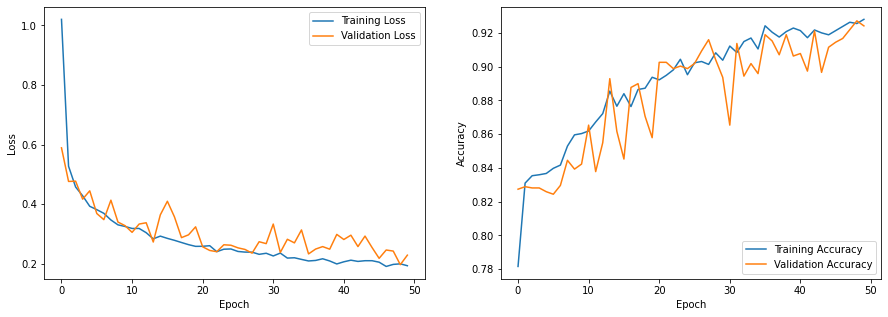

In [ ]:
def visualize_loss(hist):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(hist.history['loss'], label = 'Training Loss')
    ax1.plot(hist.history['val_loss'], label = 'Validation Loss')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    
    ax2.plot(hist.history['accuracy'], label = 'Training Accuracy')
    ax2.plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="lower right")
    
    plt.show()

visualize_loss(history)

Based on the validation loss and accuracy, it appears that the model may have started to overfit around epoch 10. After this point, both validation loss and accuracy seem to plateau or even start to degrade while training loss and accuracy continue to improve. This indicates that the model is not generalizing well for unseen data, which is a sign of overfitting. To address this issue, further hyperparameter tuning or regularization techniques should be employed in order to prevent future performance degradation from occurring due to overfitting.

In [ ]:
model.save_weights('first_model.h5')

In [ ]:
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

score = model.evaluate(tests_gen, verbose = 2)

print('\nTest loss:',   "{:.4f}".format(score[0])) 
print('Test accuracy:', "{:.4f}".format(score[1]))

pred_prob = model.predict(tests_gen)
predictions = pred_prob > 0.5

cm = confusion_matrix(y_true = tests_gen.classes, y_pred = predictions)
class_report = classification_report(tests_gen.classes, predictions, target_names=["benign", "malignant"])

26/26 - 5s - loss: 0.1818 - accuracy: 0.9333 - 5s/epoch - 184ms/step

Test loss: 0.1818
Test accuracy: 0.9333
26/26 [==============================] - 5s 205ms/step


## Using pre-trained CNN model

In [ ]:
device_name = tf.test.gpu_device_name()

if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


The Visual Geometry Group (VGG) at the University of Oxford originally presented the convolutional neural network (CNN) architecture known as VGG16 in 2014. It was created for image classification problems and has 16 convolutional and fully linked layers.

VGG16's deep architecture, which enables it to learn progressively complicated aspects from the input images, is its important characteristic. To extract information from the input image, it uses small convolutional filters (3x3) and max pooling layers. The final classification determination is then made by the network once it has passed the characteristics via fully linked layers.

Pretrained weights in Keras can be useful for binary classification of nodules using photos because they let us use the VGG16 network's knowledge acquired to categorize our own images. We can initialize the weights with the pretrained weights and fine-tune the network for our particular purpose rather than training the network from scratch on our own dataset. In comparison to starting from scratch while training the network, this method can save a significant amount of time and computational resources and produce higher results.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.constraints import MaxNorm
from keras.applications import VGG16
from keras.models import Model

with tf.device(device_name):

    vgg = VGG16(
        input_shape = (50,50,3), 
        weights = "imagenet", 
        include_top = False)

    for layer in vgg.layers:
        layer.trainable = False

    x = Flatten()(vgg.output)
    x = Dense(256, activation = "relu", kernel_constraint=MaxNorm(3))(x)  
    x = Dropout(0.5)(x)
    x = Dense(64, activation = "relu", kernel_constraint=MaxNorm(3))(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation = "sigmoid")(x) 

    vgg_model = Model(
        inputs = vgg.input, 
        outputs = x
    )

    METRICS = [
        metrics.BinaryAccuracy(name="accuracy"),
        metrics.Precision(name="precision"),
        metrics.Recall(name="recall"),
        metrics.AUC(name="auc")]
    
    vgg_model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = METRICS)

VGG training took many hours, probably due to the large number of parameters of the pre-trained VGG16.

In [ ]:
vgg_history = vgg_model.fit(train_gen, epochs = 50, validation_data = valid_gen)

Epoch 1/50
82/82 [==============================] - 73s 864ms/step - loss: 1.5468 - accuracy: 0.7734 - precision: 0.2982 - recall: 0.2923 - auc: 0.6250 - val_loss: 0.5088 - val_accuracy: 0.8289 - val_precision: 0.5854 - val_recall: 0.1013 - val_auc: 0.7112
Epoch 2/50
82/82 [==============================] - 78s 948ms/step - loss: 0.6310 - accuracy: 0.8136 - precision: 0.4072 - recall: 0.3158 - auc: 0.6838 - val_loss: 0.4639 - val_accuracy: 0.8318 - val_precision: 0.7143 - val_recall: 0.0840 - val_auc: 0.7073
Epoch 3/50
82/82 [==============================] - 75s 916ms/step - loss: 0.5040 - accuracy: 0.8266 - precision: 0.4438 - recall: 0.2588 - auc: 0.7095 - val_loss: 0.4158 - val_accuracy: 0.8363 - val_precision: 0.6970 - val_recall: 0.0987 - val_auc: 0.7282
Epoch 4/50
82/82 [==============================] - 75s 919ms/step - loss: 0.4380 - accuracy: 0.8422 - precision: 0.5419 - recall: 0.2552 - auc: 0.7308 - val_loss: 0.4013 - val_accuracy: 0.8378 - val_precision: 0.8667 - val_recal

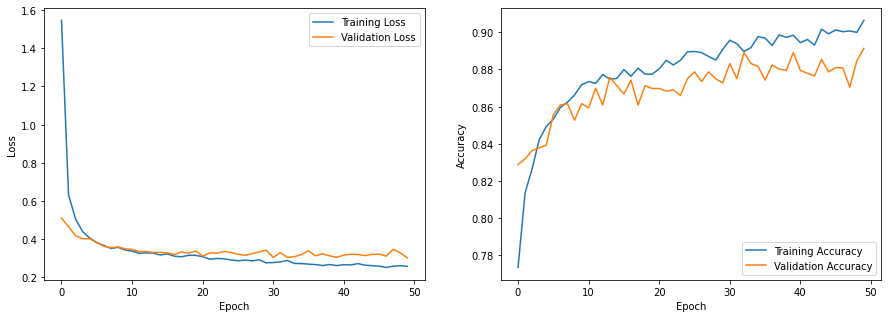

In [ ]:
visualize_loss(vgg_history)

In [ ]:
vgg_model.save_weights('vgg_model.h5')

In [ ]:
score = vgg_model.evaluate(tests_gen, verbose = 2)

print('\nTest loss:',   "{:.4f}".format(score[0])) 
print('Test accuracy:', "{:.4f}".format(score[1]))

pred_prob = vgg_model.predict(tests_gen)
predictions = pred_prob > 0.5

26/26 - 26s - loss: 1.7560 - accuracy: 0.7380 - precision: 0.0857 - recall: 0.0515 - auc: 0.4195 - 26s/epoch - 984ms/step

Test loss: 1.7560
Test accuracy: 0.7380
26/26 [==============================] - 25s 961ms/step


### Modify our proposed CNN model

In this modified LeNet model, we have increased the number of filters in the first convolutional layer to 64 and the second convolutional layer to 128. By doing so, we increase the capacity of the model to capture more complex features in the input data.

Note that increasing the number of filters can also increase the number of parameters in the model, making it more prone to overfitting. Therefore, it is important to use regularization techniques, as described in the previous answer, to prevent overfitting when increasing the capacity of the model.

We also added L2 regularization to the weights of the fully connected layers. We have also included dropout layers after each fully connected layer with a dropout rate of 0.5 to randomly drop out some of the neurons during training, which helps prevent overfitting. We set the L2 regularization strength to 0.01, which means that the magnitude of the weight coefficients is being constrained to be small. By doing so, we prevent the model from overemphasizing certain features in the input data that may be specific to the training set, reducing overfitting.






In [ ]:
from keras import regularizers

class ImprovedCNN(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(64,  3, padding='same', activation='relu')
        self.conv2 = Conv2D(128, 3, padding='same', activation='relu')
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2))
        self.maxpool2 = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(0.01))
        self.dropout1 = Dropout(0.5)
        self.fc2 = Dense(32,  activation = 'relu', kernel_regularizer=regularizers.l2(0.01))
        self.dropout2 = Dropout(0.5)
        self.fc3 = Dense(2, kernel_regularizer=regularizers.l2(0.01))

        self.batchnorm1 = BatchNormalization()
        self.batchnorm2 = BatchNormalization()

    def call(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = Activation('relu')(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = Activation('relu')(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

improved_model = ImprovedCNN()
improved_model.compile(optimizer = 'adam',
                       loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                       metrics = ['accuracy'])
improved_history = improved_model.fit(train_gen, epochs = 50, validation_data = valid_gen)

Epoch 1/50
82/82 [==============================] - 93s 1s/step - loss: 5.5931 - accuracy: 0.7710 - val_loss: 3.3403 - val_accuracy: 0.8259
Epoch 2/50
82/82 [==============================] - 58s 706ms/step - loss: 2.3693 - accuracy: 0.8289 - val_loss: 1.7697 - val_accuracy: 0.8296
Epoch 3/50
82/82 [==============================] - 43s 523ms/step - loss: 1.3616 - accuracy: 0.8371 - val_loss: 1.1525 - val_accuracy: 0.8281
Epoch 4/50
82/82 [==============================] - 43s 521ms/step - loss: 0.9848 - accuracy: 0.8354 - val_loss: 0.8843 - val_accuracy: 0.8281
Epoch 5/50
82/82 [==============================] - 42s 517ms/step - loss: 0.8171 - accuracy: 0.8458 - val_loss: 0.7953 - val_accuracy: 0.8259
Epoch 6/50
82/82 [==============================] - 49s 603ms/step - loss: 0.7419 - accuracy: 0.8508 - val_loss: 0.7187 - val_accuracy: 0.8296
Epoch 7/50
82/82 [==============================] - 60s 727ms/step - loss: 0.6623 - accuracy: 0.8559 - val_loss: 0.7289 - val_accuracy: 0.8318
Ep

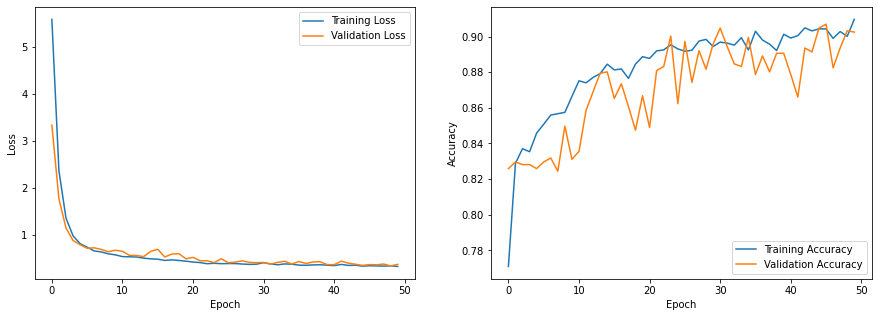

In [ ]:
visualize_loss(improved_history)

In [ ]:
improved_model.save_weights('improved_model.h5')

In [ ]:
score = improved_model.evaluate(tests_gen, verbose = 2)

print('\nTest loss:',   "{:.4f}".format(score[0])) 
print('Test accuracy:', "{:.4f}".format(score[1]))

pred_prob = improved_model.predict(tests_gen)
predictions = pred_prob > 0.5

26/26 - 7s - loss: 0.3552 - accuracy: 0.9002 - 7s/epoch - 259ms/step

Test loss: 0.3552
Test accuracy: 0.9002
26/26 [==============================] - 6s 236ms/step
